<a href="https://colab.research.google.com/github/hyguozz/DNAm-Aging-clock/blob/main/Aging_VAE_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
%tensorflow_version 2.x
import tensorflow as tf
import time
import numpy as np

Found GPU at: /device:GPU:0


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 9.1 MB/s 


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data.sampler as sampler
from sklearn.impute import KNNImputer
import numpy as np
import os
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 7.8 MB/s 


In [ ]:
import shap

In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/Aging/data/

/content/drive/MyDrive/Aging/data


In [ ]:
# May 30, 2022
# Good
#infile = open('/content/drive/MyDrive/Aging/TrainDatasetI17.pkl','rb')
infile = open('/content/drive/MyDrive/Aging/TrainDatasetI530.pkl','rb')
DNAm_data_train= pickle.load(infile)
#DNAm_data_train = DNAm_data_train[DNAm_data_train['age']<100]
train = DNAm_data_train.copy()
df_age01 = train[train['age']<=0].copy()
df_age01 = df_age01.sample(n = 100)
train = train[train['age']>0].copy().append(df_age01)
train.loc[train['dataset']=='GSE59157','age']= train.loc[train['dataset']=='GSE59157','age']/12

#infile = open('/content/drive/MyDrive/Aging/TestDatasetI17.pkl','rb')
infile = open('/content/drive/MyDrive/Aging/TestDatasetI530.pkl','rb')
DNAm_data= pickle.load(infile)
#DNAm_data = DNAm_data[DNAm_data['age']<100]
test = DNAm_data.copy()
df_age0 = test[test['age']<=0].copy()
df_age0 = df_age0.sample(n = 40)
test = test[test['age']>0].copy().append(df_age0)
test.loc[test['dataset']=='GSE59157','age']= test.loc[test['dataset']=='GSE59157','age']/12
test, val_data = train_test_split(test, test_size=0.10)

In [ ]:
train.shape, test.shape

((6467, 8680), (2547, 8680))

In [ ]:

Max_age = train.age.max()
Mage = np.log(Max_age+1)

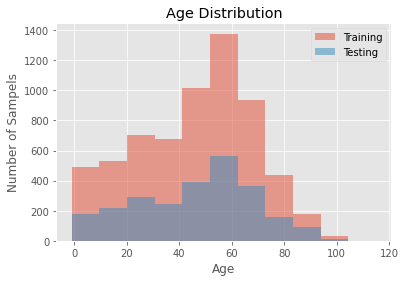

In [ ]:
import random
import numpy

import matplotlib.pyplot as plt

x = train['age'].to_numpy()
y = test['age'].to_numpy()

bins = numpy.linspace(-1, 115, 12)

plt.hist(x, bins, alpha=0.5, label='Training')
plt.hist(y, bins, alpha=0.5, label='Testing')
plt.legend(loc='upper right')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Sampels')
plt.savefig('HistTestTrain_Used_17.png', dpi = 300)
plt.show()


In [ ]:
test.shape, val_data.shape

((3008, 6699), (335, 6699))

In [ ]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(DNAm_X)
DNAm_X = transformer.transform(DNAm_X)

In [ ]:
train, test = train_test_split(DNAm_data, test_size=0.2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import Image

import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

Now I should explain why did I choose to divide the logarithm of the age by 4.75 (on the __getitem__ method from the dataset class) and why did I apply a sigmoid to the output of the age’s head (on the model definition).
In theory the loss function should be able to learn the weights and scale each task’s loss. But in fact, in my experiments I concluded that keeping the task specific losses kind of in the same scale helps a lot in the fitting process. So I divided the logarithm of the ages by 4.75 because that is the maximum value of the log(age). So the result from log(age)/4.75 should be a number between zero and one and then the MSE loss wouldn’t be so bigger than the other losses. I applied a sigmoid after the age’s head so that I can force my model to always output a prediction in the acceptable range.

# Part II
# Feb. 21, 2022
## VAE part

In [ ]:

bs = 32
epochs = 2

In [ ]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def flatten(x):
    return to_var(x.view(x.size(0), -1))

'''
def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)
'''



"\ndef save_image(x, path='real_image.png'):\n    torchvision.utils.save_image(x, path)\n"

In [ ]:
# May16

train_x = torch.from_numpy(train.iloc[:,3:].values).float()
train_y = torch.from_numpy(train['age'].astype("float").values).float()
train_dataset = torch.utils.data.TensorDataset(train_x, train_y) 

test_x = torch.from_numpy(test.iloc[:,3:].values).float()
test_y = torch.from_numpy(test['age'].astype("float").values).float()
test_dataset = torch.utils.data.TensorDataset(test_x, test_y) 

traindata_loader  = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=bs,      # mini batch size
    shuffle=True,
    drop_last=True
)

testdata_loader  = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=bs,      # mini batch size
    shuffle=True,
    drop_last=True
)

val_x = torch.from_numpy(val_data.iloc[:,3:].values).float()
val_y = torch.from_numpy(val_data['age'].astype("float").values).float()
val_dataset = torch.utils.data.TensorDataset(val_x, val_y) 

valdata_loader  = torch.utils.data.DataLoader(
    dataset=val_dataset,      # torch TensorDataset format
    batch_size=bs,      # mini batch size
    shuffle=True,
    drop_last=True
)

feature_size = DNAm_data.shape[1]-3

In [ ]:
feature_size

8677

In [ ]:
# May 15, 2022

class VAE(nn.Module):
    def __init__(self, image_size= feature_size, h_dim_1 = 64, h_dim_2 = 32, z_dim=16):
        super(VAE, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Linear(image_size, h_dim_1),
            nn.BatchNorm1d(h_dim_1),
            nn.LeakyReLU(0.2))

        self.encoder2 = nn.Sequential(
            nn.Linear(h_dim_1, h_dim_1),
            nn.BatchNorm1d(h_dim_1),
            nn.LeakyReLU(0.2)
        )
        
        self.encoder_22 = nn.Sequential(
            nn.Linear(h_dim_2, h_dim_2),
            nn.BatchNorm1d(h_dim_2),
            nn.LeakyReLU(0.2)
        )
        
        self.encoder3 = nn.Sequential(
            nn.Linear(h_dim_1, h_dim_2),
            nn.BatchNorm1d(h_dim_2),
            nn.LeakyReLU(0.2)
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(h_dim_2, z_dim*2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(h_dim_1, z_dim),
            nn.LeakyReLU(0.2)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim_2, z_dim),
            nn.LeakyReLU(0.2)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(h_dim_1, z_dim),
            nn.LeakyReLU(0.2)
        )
  
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim_2),
            nn.BatchNorm1d(h_dim_2),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim_2, h_dim_1),
            nn.BatchNorm1d(h_dim_1),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim_1, image_size),
            nn.Sigmoid()
        )

        self.task2 = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
# predict age 
        self.task3 = nn.Sequential(
            nn.Linear(z_dim*6, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32,1)
            #nn.Sigmoid()
        )
        

    def reparameterize(self, mu, logvar):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
          h1 = self.encoder1(x)
          h2 = self.encoder3(h1)
          h3 = self.encoder_22(h2)
          h32 = self.encoder_22(h3)
          h33 = self.encoder_22(h32)
          #h34 = self.encoder_22(h33)
          h4 = self.encoder(h33)
          mu, logvar = torch.chunk(h4, 2, dim=1)
          z = self.reparameterize(mu, logvar)
          #z2 = torch.cat((x1, x2.detach()), dim=1) 

          z1 = self.fc1(h1)
          z2 = self.fc2(h2)
          z3 = self.fc2(h3)
          z31 = self.fc2(h32)
          z32 = self.fc2(h33)
          #z33 = self.fc2(h34)
          z4 = torch.cat((z,z2,z1,z3,z31,z32), 1)
          #pre_age = self.task2(z)
          pre_age = self.task3(z4)
          return self.decoder(z), mu, logvar, pre_age


In [ ]:
# define the learning parameters for training
epochs = 50
batch_size = 32
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Feb. 28, 2022
def loss_fn(recon_x, x, mu, logvar, label_age, pre_age):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 8192), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss_task2 = F.mse_loss(pre_age, to_var(torch.log(label_age+1)/4.62))
    print(loss_task2)
    return BCE + KLD + loss_task2

Now I should explain why did I choose to divide the logarithm of the age by 4.75 (on the __getitem__ method from the dataset class) and why did I apply a sigmoid to the output of the age’s head (on the model definition).
In theory the loss function should be able to learn the weights and scale each task’s loss. But in fact, in my experiments I concluded that keeping the task specific losses kind of in the same scale helps a lot in the fitting process. So I divided the logarithm of the ages by 4.75 because that is the maximum value of the log(age). So the result from log(age)/4.75 should be a number between zero and one and then the MSE loss wouldn’t be so bigger than the other losses. I applied a sigmoid after the age’s head so that I can force my model to always output a prediction in the acceptable range.

In [ ]:
enumerate(testdata_loader)

In [ ]:
transformer = RobustScaler().fit(train.iloc[:,:-1])
train1 = transformer.transform(train.iloc[:,:-1])
train_x = torch.from_numpy(train1).float()

transformer = RobustScaler().fit(test.iloc[:,:-1])
test1 = transformer.transform(test.iloc[:,:-1])
test_x = torch.from_numpy(test1).float()

#train_x = torch.from_numpy(train1).float()
train_y = torch.from_numpy(train.iloc[:,-1].values).float() 
train_dataset = torch.utils.data.TensorDataset(train_x, train_y) 

#test_x = torch.from_numpy(test.iloc[:,:-1].values).float()
test_y = torch.from_numpy(test.iloc[:,-1].values).float() 
test_dataset = torch.utils.data.TensorDataset(test_x, test_y) 

traindata_loader  = torch.utils.data.DataLoader(
    dataset=train_dataset,      # torch TensorDataset format
    batch_size=bs,      # mini batch size
    shuffle=True
)

testdata_loader  = torch.utils.data.DataLoader(
    dataset=test_dataset,      # torch TensorDataset format
    batch_size=bs,      # mini batch size
    shuffle=True
)


In [ ]:
# define the validation function
def validate(model):
    #print('Validating')
    model.eval()
    run_loss = 0.0
    counter = 0
    flag_age = 11
    number_sample = val_data.shape[0]
    with torch.no_grad():
        for idx, (test_DNAm_x, lab_age) in enumerate(valdata_loader):
        #for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
            counter += 1
            test_DNAm_x = flatten(test_DNAm_x) 
            recon_x, mu, logvar, pre_age = model(test_DNAm_x)
        #print(idx, images.shape,lab_age)
        # Caluculate loss_task1 for VAE 
            BCE = F.binary_cross_entropy(recon_x, test_DNAm_x.view(-1, feature_size), reduction='sum')
            KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
            loss_task1 = BCE + KLD
            #loss_task2 = F.l1_loss(pre_age, to_var(lab_age), reduction = 'mean')
            #loss_task2 = F.l1_loss(pre_age, to_var(np.log(lab_age+1)),reduction = 'mean') 
            #loss_task3 = F.mse_loss(pre_age.view(-1), to_var(lab_age),reduction = 'sum') 
            if flag_age ==1:
              loss_task3 = F.mse_loss(pre_age.view(-1), to_var(lab_age),reduction = 'sum')
            elif flag_age ==2:
              loss_task3 = F.mse_loss(pre_age.view(-1), to_var(torch.log(lab_age+1)/Mage),reduction = 'sum') 
            else:
              loss_task3 = F.mse_loss(pre_age.view(-1), to_var(torch.log(lab_age+2)),reduction = 'sum') 
             
            #loss_task2 = F.mse_loss(pre_age.view(-1), to_var(torch.log(lab_age+1)/Mage),reduction = 'sum') 
            #loss_task2 = F.l1_loss(pre_age, to_var(np.log(lab_age+1)), reduction = 'mean')
            #loss_task2 = F.L1Loss(pre_age, to_var(np.log(lab_age+1))) #to_var(torch.log(lab_age+1)/Mage))
       # print(loss_task2)
            #loss = loss_task1 + loss_task2
            run_loss += loss_task3.item() 
    
    epoch_loss = run_loss / number_sample
    #print(f"Val Loss: {epoch_loss:.3f}")  
    # save the reconstructed images every 5 epochs
    
    return epoch_loss

In [ ]:
test_x = test.iloc[:,:-1]
test_y =test.iloc[:,-1]

In [ ]:
epochs = 200
w1 = 0.0005
lr = 0.001
model = VAE()
weight_decay = 0.0001
if torch.cuda.is_available():
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #, weight_decay = weight_decay)

flag_age = 11 # age 
train_loss_list_age = [] #
val_loss_list_age = []
train_loss_list_vae = []
num_sample = train.shape[0]
best_epoch =0
saved_loss_age =100000


In [ ]:
epochs = 50

In [ ]:
for epoch in range(epochs):
    loss = 0.0
    train_loss_age = 0.0
    train_loss_vae = 0.0
    val_loss_age = 0.0
    total_iter = len(traindata_loader)
    #total_loss,total_recon_loss,total_kl_loss=0.,0.,0.
    end = time.time()

    for idx, (train_DNAm_x, lab_age) in enumerate(traindata_loader):
        
        train_DNAm_x = flatten(train_DNAm_x) 
        recon_x, mu, logvar, pre_age = model(train_DNAm_x)
        #print(idx, images.shape,lab_age)
        # Caluculate loss_task1 for VAE 
        BCE = F.binary_cross_entropy(recon_x, train_DNAm_x.view(-1,feature_size ), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        loss_task1 = BCE + KLD

        #loss_task2 = F.l1_loss(pre_age, to_var(np.log(lab_age+1)),reduction = 'mean') 
        ###loss_task2 = F.mse_loss(pre_age.view(-1), to_var(torch.log(lab_age+1)/Mage),reduction = 'sum') 
        if flag_age ==1:
            loss_task3 = F.mse_loss(pre_age.view(-1), to_var(lab_age),reduction = 'sum')
        elif flag_age ==2:
            loss_task3 = F.mse_loss(pre_age.view(-1), to_var(torch.log(lab_age+1)/Mage),reduction = 'sum') 
        else:
            loss_task3 = F.mse_loss(pre_age.view(-1), to_var(torch.log(lab_age+2)),reduction = 'sum') 
        #print(pre_age.shape, to_var(torch.log(lab_age+1)/Mage))
        #loss_task2 = F.l1_loss(pre_age, to_var(lab_age), reduction = 'mean')
        #loss_task2 = F.mse_loss(pre_age, to_var(np.log(lab_age+1))) 
        #to_var(torch.log(lab_age+1)/Mage))to_var(torch.log(lab_age+1)/Mage))
     #   print(loss_task1)
        loss = w1*loss_task1 + loss_task3

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_age += loss_task3.item()
        train_loss_vae += loss_task1.item()
        
        # measure elasped time

        end = time.time()
    train_loss_age = train_loss_age /num_sample
    train_loss_vae = train_loss_vae / num_sample

    #print(f"Train loss all:{ epoch_loss:.3f}")
    print('Epoch: ', epoch, f"Train loss Age:{ train_loss_age:.3f}")

    val_loss_age = validate(model)
    print(f"Val loss Age:{ val_loss_age:.3f}")
    if val_loss_age < saved_loss_age:
      saved_loss_age = val_loss_age
      best_epoch = epoch
      
    train_loss_list_vae.append(train_loss_vae)
    train_loss_list_age.append(train_loss_age)
    val_loss_list_age.append(val_loss_age)

print('Best test:', val_loss_list_age.index(min(val_loss_list_age)))
print('Best train:', train_loss_list_age.index(min(train_loss_list_age)))
print('Best VAE:', train_loss_list_vae.index(min(train_loss_list_vae)))
print('Best epoch:', best_epoch)
        

Epoch:  0 Train loss Age:0.334
Val loss Age:3.964
Epoch:  1 Train loss Age:0.025
Val loss Age:3.582
Epoch:  2 Train loss Age:0.012
Val loss Age:3.756
Epoch:  3 Train loss Age:0.008
Val loss Age:3.905
Epoch:  4 Train loss Age:0.005
Val loss Age:3.813
Epoch:  5 Train loss Age:0.005
Val loss Age:3.835
Epoch:  6 Train loss Age:0.004
Val loss Age:4.023
Epoch:  7 Train loss Age:0.004
Val loss Age:3.796
Epoch:  8 Train loss Age:0.004
Val loss Age:3.938
Epoch:  9 Train loss Age:0.004
Val loss Age:3.810
Epoch:  10 Train loss Age:0.003
Val loss Age:3.803
Epoch:  11 Train loss Age:0.003
Val loss Age:3.818
Epoch:  12 Train loss Age:0.003
Val loss Age:3.865
Epoch:  13 Train loss Age:0.003
Val loss Age:3.957
Epoch:  14 Train loss Age:0.003
Val loss Age:3.861
Epoch:  15 Train loss Age:0.002
Val loss Age:3.811
Epoch:  16 Train loss Age:0.002
Val loss Age:3.844
Epoch:  17 Train loss Age:0.003
Val loss Age:3.810
Epoch:  18 Train loss Age:0.002
Val loss Age:3.895
Epoch:  19 Train loss Age:0.003
Val loss 

(3.6656895, 4.948313, 51.34214, array([[1.        , 0.95983651],
        [0.95983651, 1.        ]]))

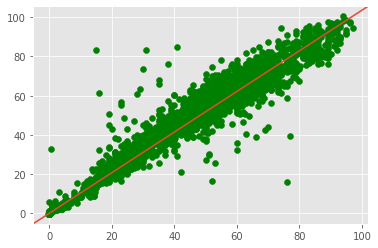

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

number_sample = test.shape[0]
pred_age_list = []
ground_age_list = []
with torch.no_grad():
    for idx, (test_DNAm_x, lab_age) in enumerate(testdata_loader):
    #for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
        test_DNAm_x = flatten(test_DNAm_x) 
        recon_x, mu, logvar, pre_age = model(test_DNAm_x)

        pred_age_list.extend(pre_age.view(-1).cpu().data.numpy() )
        ground_age_list.extend(lab_age.cpu().data.numpy())

#y = list(map(lambda y1: np.exp(y1*Mage) -1, pred_age_list))
#y = list(map(lambda y1: np.exp(y1) -1, pred_age_list))
y= pred_age_list
x = ground_age_list

fig, ax = plt.subplots()
ax.scatter(x, y, c='g')
ax.plot([0,1],[0,1], transform=ax.transAxes)

median_absolute_error(x,y),mean_absolute_error(x,y), mean_squared_error(x,y), np.corrcoef(x,y)




In [ ]:
import shap

In [ ]:
# build mlp
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mean_squared_error', optimizer = 'adam')
# fit model
#model.fit(x_train, y_train, epochs=10, batch_size=64)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, verbose=0,batch_size=64)

In [ ]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mse'])
# fit model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, verbose=0)
# evaluate the model
_, train_mse = model.evaluate(x_train, y_train, verbose=0)
_, test_mse = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot mse during training
pyplot.subplot(212)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mean_squared_error'], label='train')
pyplot.plot(history.history['val_mean_squared_error'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:

# mlp for regression with msle loss function
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from matplotlib import pyplot

In [ ]:

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, verbose=0)
# evaluate the model
train_mse = model.evaluate(x_train, y_train,  verbose=0)
test_mse = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training# compute SHAP values


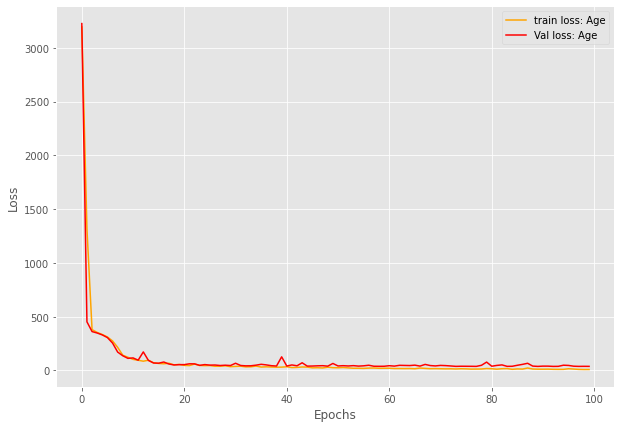

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss_list_age, color='orange', label='train loss: Age')
plt.plot(val_loss_list_age, color='red', label='Val loss: Age')
#plt.plot(train_loss_list_vae, color='green', label='VAE loss')
#plt.plot(train_loss_list_vae, color='green', label='VAE loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('../outputs/loss.png')
plt.show()

# Age ground truth

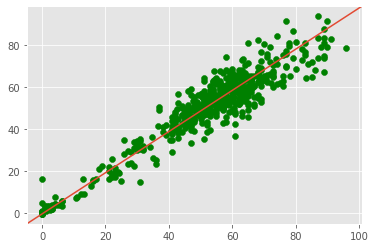

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#fig,ax = plt.subplots(1)

# create some x data and some integers for the y axi
#x = (torch.log(lab_age+1)/Mage)
#y = torch.log(lab+1)/Mage

number_sample = test.shape[0]
pred_age_list = []
ground_age_list = []
with torch.no_grad():
    for idx, (test_DNAm_x, lab_age) in enumerate(testdata_loader):
    #for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
        test_DNAm_x = flatten(test_DNAm_x) 
        recon_x, mu, logvar, pre_age = model(test_DNAm_x)

        pred_age_list.extend(pre_age.view(-1).cpu().data.numpy() )
        ground_age_list.extend(lab_age.cpu().data.numpy())

y =  pred_age_list
#y = to_var(torch.log(lab_age+1)/Mage).cpu().data.numpy()
x = ground_age_list
# plot the data

fig, ax = plt.subplots()
ax.scatter(x, y, c='g')
ax.plot([0,1],[0,1], transform=ax.transAxes)

In [ ]:
sum1=0.0
for i in range(len(x)):
  mae1= np.abs(x[i]-y[i])
  sum1 += mae1

print(sum1/len(x))

6.25400292225161


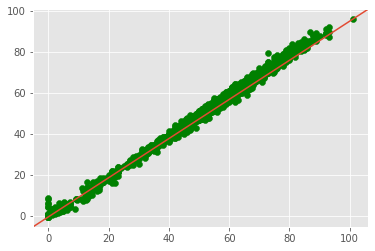

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#fig,ax = plt.subplots(1)

# create some x data and some integers for the y axi
#x = (torch.log(lab_age+1)/Mage)
#y = torch.log(lab+1)/Mage

number_sample = train.shape[0]
pred_age_list = []
ground_age_list = []
with torch.no_grad():
    for idx, (test_DNAm_x, lab_age) in enumerate(traindata_loader):
    #for i, data in tqdm(enumerate(dataloader), total=int(len(testset)/dataloader.batch_size)):
        test_DNAm_x = flatten(test_DNAm_x) 
        recon_x, mu, logvar, pre_age = model(test_DNAm_x)

        pred_age_list.extend(pre_age.view(-1).cpu().data.numpy() )
        ground_age_list.extend(lab_age.cpu().data.numpy())

y =  pred_age_list
#y = to_var(torch.log(lab_age+1)/Mage).cpu().data.numpy()
x = ground_age_list
# plot the data

fig, ax = plt.subplots()
ax.scatter(x, y, c='g')
ax.plot([0,1],[0,1], transform=ax.transAxes)